In [1]:
import pandas as pd
import glob

# Table of Contents
 <p><div class="lev1"><a href="#Task-1.-Compiling-Ebola-Data"><span class="toc-item-num">Task 1.&nbsp;&nbsp;</span>Compiling Ebola Data</a></div>
 <div class="lev1"><a href="#Task-2.-RNA-Sequences"><span class="toc-item-num">Task 2.&nbsp;&nbsp;</span>RNA Sequences</a></div>
 <div class="lev1"><a href="#Task-3.-Class-War-in-Titanic"><span class="toc-item-num">Task 3.&nbsp;&nbsp;</span>Class War in Titanic</a></div></p>

In [3]:
DATA_FOLDER = 'Data' # Use the data folder provided in Tutorial 02 - Intro to Pandas.

## Task 1. Compiling Ebola Data

The `DATA_FOLDER/ebola` folder contains summarized reports of Ebola cases from three countries (Guinea, Liberia and Sierra Leone) during the recent outbreak of the disease in West Africa. For each country, there are daily reports that contain various information about the outbreak in several cities in each country.

Use pandas to import these data files into a single `Dataframe`.
Using this `DataFrame`, calculate for *each country*, the *daily average* per year of *new cases* and *deaths*.
Make sure you handle all the different expressions for *new cases* and *deaths* that are used in the reports.

---
### Main idea :

1. group reports by country, and group them creating a new `Country` row
2. calculate for each country, *daily average* per year of *new cases* and *deaths* 


---
1.


In [4]:
path = "Data/ebola"
countries = [("Guinea","guinea_data"), ("Liberia","liberia_data"), ("Sierra Leone","sl_data")]

data = pd.DataFrame()

for country in countries:
    allFiles = glob.glob(path + "/" + country[1] + "/" + "/*csv")
    data_per_country = pd.concat((pd.read_csv(file) for file in allFiles), axis=0)
    data_per_country['Country'] = country[0]
    data = pd.concat([data, data_per_country])

# merge columns 'Date' and 'date'
data['Date'] = pd.concat([data['Date'].dropna(), data['date'].dropna()])
data = data.drop('date', axis=1)

# re-ordering indexes
data.set_index(['Country', 'Date']).head()


34 Military Hospital Beyla   Bo  Bo EMC Boffa Bombali  \
Country Date                                                                
Guinea  2014-09-17                   NaN   NaN  NaN     NaN   NaN     NaN   
        2014-09-17                   NaN   NaN  NaN     NaN   NaN     NaN   
        2014-09-17                   NaN   NaN  NaN     NaN   NaN     NaN   
        2014-09-17                   NaN   NaN  NaN     NaN     0     NaN   
        2014-09-17                   NaN   NaN  NaN     NaN     0     NaN   

                    Bomi County  Bong County Bonthe Conakry    ...     \
Country Date                                                   ...      
Guinea  2014-09-17          NaN          NaN    NaN       3    ...      
        2014-09-17          NaN          NaN    NaN     NaN    ...      
        2014-09-17          NaN          NaN    NaN       2    ...      
        2014-09-17          NaN          NaN    NaN       5    ...      
        2014-09-17          NaN          NaN    NaN      14    ...      

                   Tonkolili Totals Unnamed: 18 Variable Western area  \
Country Date                                                            
Guinea  2014-09-17       NaN      4         NaN      NaN          NaN   
        2014-09-17       NaN      0         NaN      NaN          NaN   
        2014-09-17       NaN      6         NaN      NaN          NaN   
        2014-09-17       NaN     10         NaN      NaN          NaN   
        2014-09-17       NaN     32         NaN      NaN          NaN   

                   Western area combined Western area rural  \
Country Date                                                  
Guinea  2014-09-17                   NaN                NaN   
        2014-09-17                   NaN                NaN   
        2014-09-17                   NaN                NaN   
        2014-09-17                   NaN                NaN   
        2014-09-17                   NaN                NaN   

                    Western area urban  Yomou  variable  
Country Date                                             
Guinea  2014-09-17                 NaN    NaN       NaN  
        2014-09-17                 NaN    NaN       NaN  
        2014-09-17                 NaN    NaN       NaN  
        2014-09-17                 NaN      0       NaN  
        2014-09-17                 NaN      0       NaN  

[5 rows x 66 columns]

---
2.

In [4]:
# Guinea 
# drop useless content
data_cleaned_guinea = data.query('Country == "Guinea"').dropna(axis=1, how='all').set_index(['Date','Description'])['Totals']
data_cleaned_guinea = data_cleaned_guinea.unstack('Description')

mean_dailyNewCases_guinea = data_cleaned_guinea['Total new cases registered so far'].astype(float).mean()
mean_dailyNewDeaths_guinea = data_cleaned_guinea['New deaths registered'].astype(float).mean()

print("Guinea : ", mean_dailyNewCases_guinea, " / ", mean_dailyNewDeaths_guinea)

# Liberia
data_cleaned_liberia = data.query('Country == "Liberia"').dropna(axis=1, how='all').set_index(['Date','Variable'])['National'].astype(float)
data_cleaned_liberia = pd.pivot_table(data_cleaned_liberia.reset_index(), values='National', index='Date', columns='Variable')

mean_dailyNewCases_liberia = data_cleaned_liberia['New case/s (confirmed)'].mean()
mean_dailyNewDeaths_liberia = data_cleaned_liberia['Newly reported deaths'].mean() #.csv file from 12/09/2014 may has been wrongly fulfilled

print("Libera : ", mean_dailyNewCases_liberia, " / ", mean_dailyNewDeaths_liberia)

# Sierra Leone
data_cleaned_SL = pd.to_numeric(data.query('Country == "Sierra Leone"').dropna(axis=1, how='all').set_index(['Date','variable'])['National'], errors='coerce')
data_cleaned_SL = pd.pivot_table(data_cleaned_SL.reset_index(), values='National', index='Date', columns='variable')

#data_cleaned_SL_deaths1 = pd.to_numeric(data.query('Country == "Sierra Leone"').dropna(axis=1, how='all').reset_index().pivot_table(values='variable', index=['Data'], columns=['Kailahun', 'Kenema']), errors='coerce')
#data_cleaned_SL_deaths2 = pd.to_numeric(data.query('Country == "Sierra Leone"').dropna(axis=1, how='all').set_index(['Date','variable'])['Kenema'], errors='coerce')

t = data.query('Country == "Sierra Leone"').dropna(axis=1, how='all').set_index(['Date','variable'])
t.query('variable=="etc_new_deaths"').sum(axis=1, numeric_only=True)#.mean()

#mean_dailyNewCases_SL = data_cleaned_SL['new_confirmed'].mean()
#mean_dailyNewDeaths_SL = data_cleaned_SL['death_confirmed'].mean()

#print("Sierra Leone : ", mean_dailyNewCases_SL, " / ", mean_dailyNewDeaths_SL)

Guinea :  21.6818181818  /  4.14285714286
Libera :  207.764705882  /  23.1590909091


Date        variable      
2014-11-18  etc_new_deaths    NaN
2014-09-29  etc_new_deaths    2.0
2014-09-19  etc_new_deaths    NaN
2014-10-03  etc_new_deaths    NaN
2014-08-24  etc_new_deaths    NaN
2014-08-19  etc_new_deaths    NaN
2014-10-12  etc_new_deaths    NaN
2014-10-16  etc_new_deaths    3.0
2014-10-28  etc_new_deaths    NaN
2014-11-24  etc_new_deaths    NaN
2014-10-23  etc_new_deaths    NaN
2014-09-28  etc_new_deaths    NaN
2014-11-16  etc_new_deaths    NaN
2014-09-01  etc_new_deaths    NaN
2014-10-08  etc_new_deaths    NaN
2014-08-13  etc_new_deaths    NaN
2014-09-10  etc_new_deaths    NaN
2014-09-11  etc_new_deaths    NaN
2014-10-14  etc_new_deaths    NaN
2014-10-04  etc_new_deaths    NaN
2014-09-09  etc_new_deaths    NaN
2014-08-23  etc_new_deaths    NaN
2014-10-25  etc_new_deaths    NaN
2014-08-31  etc_new_deaths    NaN
2014-10-30  etc_new_deaths    NaN
2014-08-22  etc_new_deaths    NaN
2014-09-25  etc_new_deaths    1.0
2014-10-11  etc_new_deaths    NaN
2014-11-29  etc_new_d

## Task 2. RNA Sequences

In the `DATA_FOLDER/microbiome` subdirectory, there are 9 spreadsheets of microbiome data that was acquired from high-throughput RNA sequencing procedures, along with a 10<sup>th</sup> file that describes the content of each. 

Use pandas to import the first 9 spreadsheets into a single `DataFrame`.
Then, add the metadata information from the 10<sup>th</sup> spreadsheet as columns in the combined `DataFrame`.
Make sure that the final `DataFrame` has a unique index and all the `NaN` values have been replaced by the tag `unknown`.

In [15]:
path_RNA = "Data/microbiome"

data_RNA = pd.DataFrame()

allFiles_RNA = glob.glob(path_RNA + "/MID*.xls")
metadata_RNA = path_RNA + "/metadata.xls"

# concat all the MID* files
data_RNA = pd.concat((pd.read_excel(file, index_col=0, names=[file[16:-4]]) for file in allFiles_RNA), axis=1)

# transpose index/columns and sort indexes
data_RNA = data_RNA.T#.reindex(index=sorted(data_RNA.columns))

# add last file as columns
data_RNA = pd.concat([data_RNA, pd.read_excel(metadata_RNA, index_col=0)], axis=1)

# replace NaN values by 'unknown'
data_RNA = data_RNA.fillna(value='unknown')

#data.index.is_unique #True
data_RNA.head()

Index(['MID3', 'MID9', 'MID7', 'MID1', 'MID6', 'MID8', 'MID2', 'MID4', 'MID5'], dtype='object')


,"Archaea ""Crenarchaeota"" Thermoprotei Acidilobales Caldisphaeraceae Caldisphaera","Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Desulfurococcaceae Ignisphaera","Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Desulfurococcaceae Stetteria","Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Desulfurococcaceae Sulfophobococcus","Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Desulfurococcaceae Thermodiscus","Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Desulfurococcaceae Thermosphaera","Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Pyrodictiaceae Hyperthermus","Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Pyrodictiaceae Pyrodictium","Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Pyrodictiaceae Pyrolobus","Archaea ""Crenarchaeota"" Thermoprotei Sulfolobales Sulfolobaceae Stygiolobus",...,"Bacteria ""Verrucomicrobia"" Verrucomicrobiae Verrucomicrobiales Verrucomicrobiaceae Persicirhabdus","Bacteria ""Verrucomicrobia"" Verrucomicrobiae Verrucomicrobiales Verrucomicrobiaceae Verrucomicrobium",Bacteria Cyanobacteria Cyanobacteria Chloroplast Bangiophyceae,Bacteria Cyanobacteria Cyanobacteria Chloroplast Chlorarachniophyceae,Bacteria Cyanobacteria Cyanobacteria Chloroplast Streptophyta,Bacteria OD1 OD1_genera_incertae_sedis,Bacteria OP11 OP11_genera_incertae_sedis,Bacteria TM7 TM7_genera_incertae_sedis,GROUP,SAMPLE
MID1,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,2,3,...,unknown,unknown,2,85,1388,unknown,unknown,unknown,EXTRACTION CONTROL,unknown
MID2,14,23,unknown,1,unknown,2,1,unknown,2,10,...,unknown,unknown,unknown,1,2,unknown,unknown,2,NEC 1,tissue
MID3,15,14,unknown,4,1,1,unknown,3,unknown,4,...,2,1,1,4,54,1,26,unknown,Control 1,tissue
MID4,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,...,unknown,unknown,unknown,6,44,unknown,unknown,unknown,NEC 2,tissue
MID5,26,28,1,5,unknown,2,unknown,2,3,14,...,unknown,unknown,2,5,59,4,unknown,unknown,Control 2,tissue


## Task 3. Class War in Titanic

Use pandas to import the data file `Data/titanic.xls`. It contains data on all the passengers that travelled on the Titanic.

In [6]:
from IPython.core.display import HTML
HTML(filename=DATA_FOLDER+'/titanic.html')

Name,Labels,Units,Levels,Storage,NAs
pclass,,,3,integer,0
survived,Survived,,,double,0
name,Name,,,character,0
sex,,,2,integer,0
age,Age,Year,,double,263
sibsp,Number of Siblings/Spouses Aboard,,,double,0
parch,Number of Parents/Children Aboard,,,double,0
ticket,Ticket Number,,,character,0
fare,Passenger Fare,British Pound (\243),,double,1
cabin,,,187,integer,0


For each of the following questions state clearly your assumptions and discuss your findings:
1. Describe the *type* and the *value range* of each attribute. Indicate and transform the attributes that can be `Categorical`. 
2. Plot histograms for the *travel class*, *embarkation port*, *sex* and *age* attributes. For the latter one, use *discrete decade intervals*. 
3. Calculate the proportion of passengers by *cabin floor*. Present your results in a *pie chart*.
4. For each *travel class*, calculate the proportion of the passengers that survived. Present your results in *pie charts*.
5. Calculate the proportion of the passengers that survived by *travel class* and *sex*. Present your results in *a single histogram*.
6. Create 2 equally populated *age categories* and calculate survival proportions by *age category*, *travel class* and *sex*. Present your results in a `DataFrame` with unique index.

## Data loading

In [179]:
# load data
data_titanic = pd.read_excel('Data/titanic.xls')
data_titanic.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


## Data cleaning

In [180]:
# We are only interested in handling a few of the columns and their missing values

# We drop the row with a NaN value for Embarked since there are only two of them
# We could also replace by the most frequent value policy, and thus fill with "S" in this case
data_titanic.dropna(subset=["embarked"], inplace=True)
# Fill NaN with median value policy for fare and age
data_titanic["fare"].fillna(data_titanic["fare"].median(), inplace=True)
data_titanic["age"].fillna(data_titanic["age"].median(), inplace=True)

---
## 1. Showing types, describing data and changing to categorical types

In [206]:
data_titanic.dtypes

pclass       category
survived     category
name           object
sex          category
age           float64
sibsp           int64
parch           int64
ticket         object
fare          float64
cabin          object
embarked     category
boat           object
body          float64
home.dest      object
dtype: object

In [182]:
data_titanic.describe()

,pclass,survived,age,sibsp,parch,fare,body
count,1307.000000,1307.000000,1307.000000,1307.000000,1307.000000,1307.000000,121.000000
mean,2.296863,0.381025,29.471818,0.499617,0.385616,33.209595,160.809917
std,0.836942,0.485825,12.881598,1.042273,0.866092,51.748768,97.696922
min,1.000000,0.000000,0.166700,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,22.000000,0.000000,0.000000,7.895800,72.000000
50%,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200,155.000000
75%,3.000000,1.000000,35.000000,1.000000,0.000000,31.275000,256.000000
max,3.000000,1.000000,80.000000,8.000000,9.000000,512.329200,328.000000


In [183]:
for col in ['pclass', 'survived', 'sex', 'embarked']:
    data_titanic[col] = data_titanic[col].astype('category')
data_titanic.dtypes

pclass       category
survived     category
name           object
sex          category
age           float64
sibsp           int64
parch           int64
ticket         object
fare          float64
cabin          object
embarked     category
boat           object
body          float64
home.dest      object
dtype: object

---
## 2.

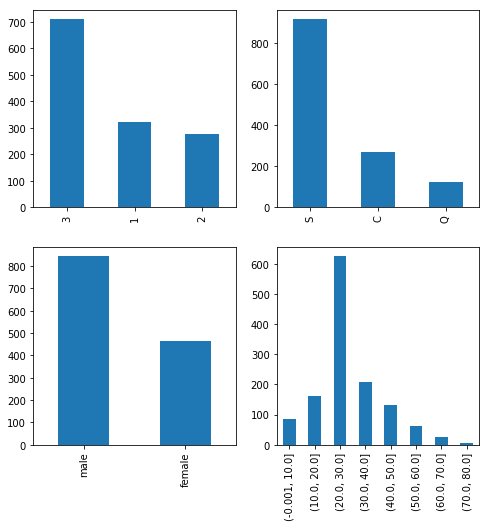

In [184]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(8,8))

plt.subplot(221)
data_titanic['pclass'].value_counts().plot(kind='bar')

plt.subplot(222)
data_titanic['embarked'].value_counts().plot(kind='bar')

plt.subplot(223)
data_titanic['sex'].value_counts().plot(kind='bar')

plt.subplot(224)
age_binned = pd.cut(data_titanic['age'], bins=[0, 10, 20, 30, 40, 50, 60, 70, 80], include_lowest=True)
age_binned.value_counts(sort=False).plot(kind='bar')

plt.show()

---
## 3.

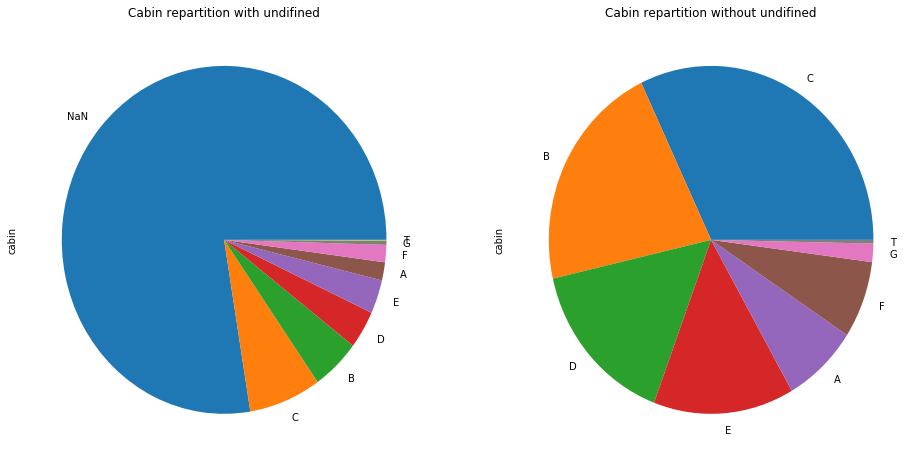

In [189]:
fig, axes = plt.subplots(1, 2, figsize=(16,8))

s = data_titanic['cabin']
s_nan = s.astype(str).str[0]
# We have to replace the N
s_nan = s_nan.replace('n', 'NaN')
s_no_nan = s.dropna().astype(str).str[0]

axes[0].set_title('Cabin repartition with undifined')
s_nan.value_counts().plot.pie(ax=axes[0])
axes[1].set_title('Cabin repartition without undifined')
s_no_nan.value_counts().plot.pie(ax=axes[1])
plt.show()

---
## 4.

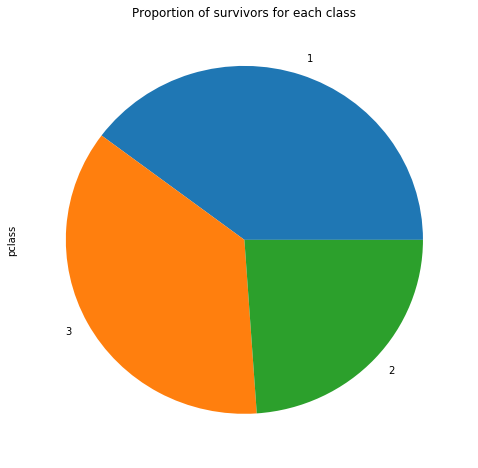

In [198]:
plt.figure(figsize=(8,8))
df = data_titanic[data_titanic['survived'] == 1]['pclass']
df.value_counts().plot.pie()
plt.title('Proportion of survivors for each class')
plt.show()

## 5.

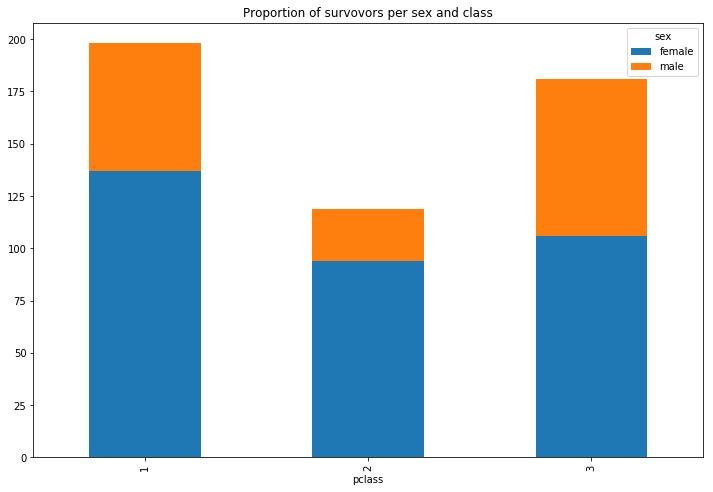

In [199]:
df = data_titanic[data_titanic['survived'] == 1]
df = df.groupby(['pclass', 'sex']).size().unstack()
df.plot.bar(stacked=True, figsize=(12,8))
plt.title('Proportion of survovors per sex and class')
plt.show()

In [210]:
df = data_titanic[['age', 'pclass', 'sex']]
df = df.sort_values('age')
# Take the median of the indices (since the median by age) will not produce two equally sized sets.
# The result will satisfy the conditions answered for the question 20) in the FAQ
# CAREFUL: df must be sorted by age before taking such a median by indices.
med_id = df.shape[0] // 2

df.iloc[:med_id]['age'] = 0.0
df.iloc[med_id:]['age'] = 1.0
df['age'] = df['age'].astype('category')

groups = pd.DataFrame(df.groupby(['age', 'pclass', 'sex']).size())
groups.reset_index(inplace=True) 
groups.columns = ['age category', 'class', 'sex', 'count']

groups

/usr/lib/python3.6/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/lib/python3.6/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,age category,class,sex,count
0,0.0,1,female,43
1,0.0,1,male,51
2,0.0,2,female,52
3,0.0,2,male,71
4,0.0,3,female,137
5,0.0,3,male,299
6,1.0,1,female,99
7,1.0,1,male,128
8,1.0,2,female,54
9,1.0,2,male,100
